In this notebook, we build a model with the hyperparameters obtained in the previous notebook (P7_05_model_02) and with RandomOverSampling (without cross-validation).

To analyze the results of the prediction on the test set, we save the result of the test set ('df_pred.csv').

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import joblib

# 2. Load Data

In [2]:
train_merge = pd.read_csv('train_merge.csv')

In [3]:
train_merge.shape

(307511, 1370)

In [4]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [5]:
sns.set_theme(style='darkgrid')

# 3. Model

In [6]:
train = train_merge.copy()

In [7]:
# Extract the ids
train_ids = train['SK_ID_CURR']
    
# Extract the labels for training
labels = train['TARGET']
    
# Remove the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [8]:
categorical_features_1 = []
categorical_features_2 = []

for col in train.select_dtypes(['object', 'bool']):
    if len(list(train[col].unique())) <= 2:
        categorical_features_1.append(col)
    else:
        categorical_features_2.append(col)

In [9]:
numerical_features = train.select_dtypes(['float64', 'int64']).columns.tolist()

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [11]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 3113.01 MB
Memory usage after optimization is: 992.12 MB
Decreased by 68.1%


In [12]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(0, 1)))
categorical_pipeline_1 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OrdinalEncoder())
categorical_pipeline_2 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore'))

In [13]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline_1, categorical_features_1), (categorical_pipeline_2, categorical_features_2))

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(train, labels, test_size=0.20, random_state=42)

In [15]:
def conf_matrix(y_test, pred):
    con_mat = confusion_matrix(y_test, pred)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(4, 4))
    plt.title('Confusion Matrix', size=15)
    sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [16]:
def get_column_names_from_ColumnTransformer(column_transformer):
    """
    Helper function which explores a Column Transformer to get feature names
    Parameters
    ----------
    column_transformer: a sklearn column_transformer
    Returns
    ----------
    a list of strings of the column names of the outputs of the colun_transformer
    """
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        if isinstance(transformer, OneHotEncoder):
            if isinstance(raw_col_name, str):
                names = transformer.get_feature_names(input_features=[raw_col_name])
            else:
                names = transformer.get_feature_names(input_features=raw_col_name)
        elif isinstance(transformer, PolynomialFeatures):
            names = transformer.get_feature_names(input_features=raw_col_name)
        else:
            try:
                names = transformer.get_feature_names()
            except AttributeError:
                # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name

# 4. Model Tuning

### First

In [17]:
Y_test = Y_test.astype(int)
Y_train = Y_train.astype(int)

In [18]:
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros = ros.fit_resample(X_train, Y_train)

In [19]:
model_lgbmc_1 = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42, num_leaves=20, n_estimators=150))

In [20]:
model_lgbmc_1.fit(X_train_ros, Y_train_ros)

[18:14:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                         

In [21]:
joblib.dump(model_lgbmc_1, 'model_lgbmc_final.pkl')

['model_lgbmc_final.pkl']

In [22]:
pred_1 = model_lgbmc_1.predict_proba(X_test)
pred_1 = pred_1[:, 1]

In [23]:
auc_1 = roc_auc_score(Y_test, pred_1)
print('AUC: ', auc_1)

AUC:  0.7827308218832982


In [24]:
pred_1_t = model_lgbmc_1.predict_proba(X_train_ros)
pred_1_t = pred_1_t[:, 1]
auc_1_t = roc_auc_score(Y_train_ros, pred_1_t)
print('AUC: ', auc_1_t)

AUC:  0.829655638774538


0.7126929786556548


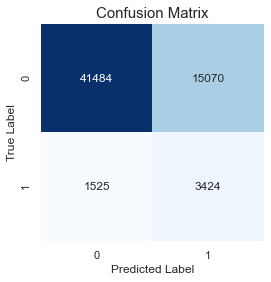

In [25]:
pred_test = model_lgbmc_1.predict(X_test)
print(roc_auc_score(Y_test, pred_test))
conf_matrix(Y_test, pred_test)

In [26]:
precision_1 = precision_score(Y_test, pred_test)
recall_1 = recall_score(Y_test, pred_test)

print('precision: ', precision_1)
print('recall: ', recall_1)

precision:  0.185141126851952
recall:  0.6918569407961205


In [27]:
mask = model_lgbmc_1['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc_1['columntransformer'])):
    if bool:
        new_features.append(feature)

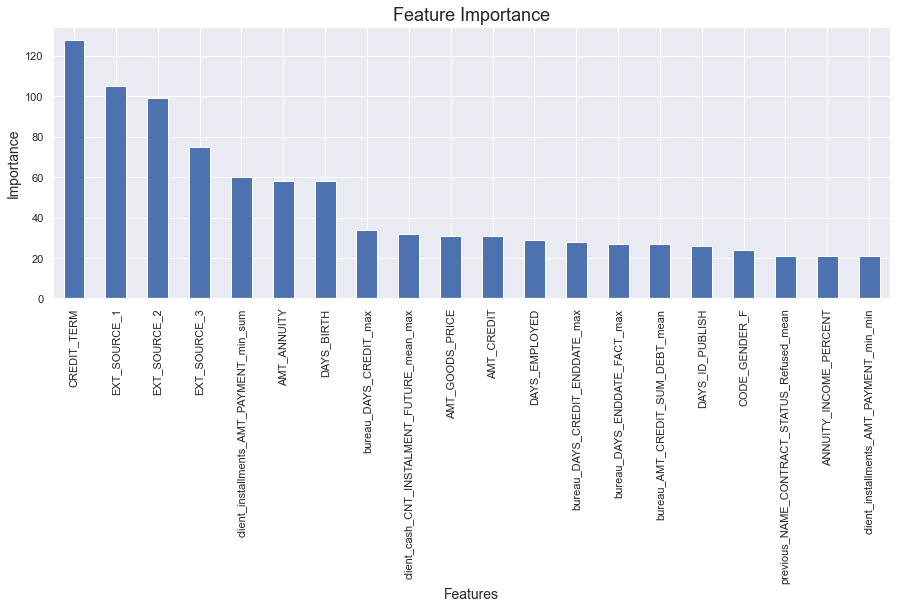

In [28]:
Importance = pd.DataFrame(model_lgbmc_1['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

#### Second

In [29]:
model_lgbmc_2 = make_pipeline(preprocessor, SelectFromModel(XGBClassifier()), LGBMClassifier(random_state=42, num_leaves=10, n_estimators=200))

In [30]:
model_lgbmc_2.fit(X_train_ros, Y_train_ros)

[18:28:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                         

In [31]:
pred_2 = model_lgbmc_2.predict_proba(X_test)
pred_2 = pred_2[:, 1]

In [32]:
auc_2 = roc_auc_score(Y_test, pred_2)
print('AUC: ', auc_2)

AUC:  0.7811374895811951


In [33]:
pred_2_t = model_lgbmc_2.predict_proba(X_train_ros)
pred_2_t = pred_2_t[:, 1]
auc_2_t = roc_auc_score(Y_train_ros, pred_2_t)
print('AUC: ', auc_2_t)

AUC:  0.8115567242548299


0.7129944105835243


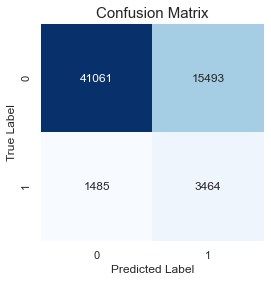

In [34]:
pred_test = model_lgbmc_2.predict(X_test)
print(roc_auc_score(Y_test, pred_test))
conf_matrix(Y_test, pred_test)

In [35]:
precision_2 = precision_score(Y_test, pred_test)
recall_2 = recall_score(Y_test, pred_test)

print('precision: ', precision_2)
print('recall: ', recall_2)

precision:  0.1827293348103603
recall:  0.6999393816932714


In [36]:
mask = model_lgbmc_2['selectfrommodel'].get_support()
new_features = []

for bool, feature in zip(mask, get_column_names_from_ColumnTransformer(model_lgbmc_2['columntransformer'])):
    if bool:
        new_features.append(feature)

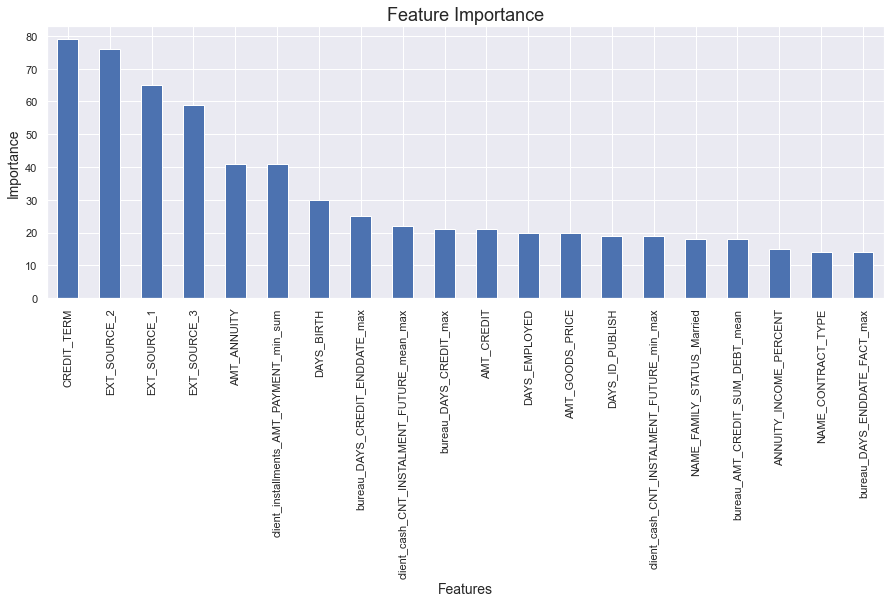

In [37]:
Importance = pd.DataFrame(model_lgbmc_2['lgbmclassifier'].feature_importances_, index = new_features, columns = ['Importance'])
plt.figure(figsize = (15,5))
Importance['Importance'].sort_values(ascending = False)[:20].plot.bar(y = 'Importance')
plt.title('Feature Importance', fontsize = 18)
plt.xlabel('Features', size = 14)
plt.ylabel('Importance', size = 14)
plt.show()

# 5. Results

In [38]:
model_name = ['First', 
              'Second']

columns_name = ['AUC', 'AUC_Training', 'Precision', 'Recall']

df_result = pd.DataFrame(index = model_name, columns = columns_name)

In [39]:
count = 1
for i in model_name:
    df_result.loc[i, 'AUC'] = vars()['auc_' + str(count)]
    count = count + 1

count = 1
for i in model_name:
    df_result.loc[i, 'AUC_Training'] = vars()['auc_' + str(count) + '_t']
    count = count + 1

count = 1
for i in model_name:
    df_result.loc[i, 'Precision'] = vars()['precision_' + str(count)]
    count = count + 1
    
count = 1
for i in model_name:
    df_result.loc[i, 'Recall'] = vars()['recall_' + str(count)]
    count = count + 1

In [40]:
df_result

,AUC,AUC_Training,Precision,Recall
First,0.782731,0.829656,0.185141,0.691857
Second,0.781137,0.811557,0.182729,0.699939


In [41]:
ids_train, ids_test, l_train, l_test = train_test_split(train_ids, labels, test_size=0.20, random_state=42)

In [42]:
X = X_test.copy()

In [43]:
X['SK_ID_CURR'] = ids_test

In [44]:
X['Prediction'] = pred_1

In [45]:
X['TARGET'] = l_test

In [46]:
X.to_csv('df_pred.csv', index=False)